# FDA Reading Room 483 Analysis

In [ ]:
from datetime import date
print("Script last ran on {}".format(date.today().strftime("%m/%d/%Y")))

In [43]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import lxml
import html5lib 
from bs4 import BeautifulSoup
import janitor
import tempfile
import os # to get current opperating system

# selenium functions
from selenium import webdriver
from selenium.webdriver.common.keys import Keys #allow  you to enter keystrokes into fields
from selenium.webdriver.support.ui import Select #allow you to select a dropdown item
from selenium.webdriver.support.ui import WebDriverWait #lets you modify a field before proceeding
from selenium.common.exceptions import NoSuchElementException 

## Step 1: Scrape Data Table and List of URLs to Form 483s from URL

__Establishment Types to Filter By__  
Outsourcing Facility, Producer of Sterile and Non Sterile Drug Products, Producer of Sterile Drug Products, Producer of Non Sterile Drug Products, Manufacturer

In [3]:
cwd = os.getcwd()
temp483pdf_filepath = cwd + '\\temp483pdf'
temp483images_filepath = cwd + '\\temp483images'

op = webdriver.ChromeOptions()
prefs = {"download.default_directory": temp483pdf_filepath,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
         "download.extensions_to_open": "applications/pdf",
        "plugins.always_open_pdf_externally": True}
#prefs2 = {"download.prompt_for_download": False,
#        "download.directory_upgrade": True,
#         "download.extensions_to_open": "applications/pdf",
#        "plugins.always_open_pdf_externally": True}
op.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(options = op)

table class = lcsd-datatable--ora-foia-reading table table-bordered dataTable no footer dtr-inline

In [4]:
# use driver to open website
url = 'https://www.fda.gov/about-fda/office-regulatory-affairs/ora-foia-electronic-reading-room'
driver.get(url)

# utilize the filter box to select only 483s (value = 0)
select = Select(driver.find_element_by_css_selector('#lcds-datatable-filter--record-filter'))
select.select_by_value('0')

# get the table headers
## read the datatable of page 1 for the sake of retrieving headers
datatable_xpath = '//*[@id="DataTables_Table_0"]'
records = driver.find_element_by_xpath(datatable_xpath)
records_innerhtml = records.get_attribute('innerHTML')
soup = BeautifulSoup(records_innerhtml, 'html.parser')
trs = soup.findAll('tr')
headers = []
for th in trs[0].findAll('th'):
    headers.append(th.text)
headers

# scrape all rows in each page of the paginated datatable
final_page = int(driver.find_element_by_xpath('//*[@id="DataTables_Table_0_paginate"]/ul/li[8]').text)
rows = []
for page in range(1, final_page + 1):
    
    datatable_xpath = '//*[@id="DataTables_Table_0"]'
    records = driver.find_element_by_xpath(datatable_xpath)
    records_innerhtml = records.get_attribute('innerHTML')
    soup = BeautifulSoup(records_innerhtml, 'html.parser')
    trs = soup.findAll('tr')
    
    for i in range(1, len(trs)):
        tds = []
        #page_rows = []
        for td in trs[i].findAll('td'):
            a = td.findAll('a')
            spans = td.findAll('span')
            inputs = td.findAll('input')
            ret = ""
            if len(a) != 0 or len(spans) != 0 or len(inputs) != 0:
                if len(a) != 0:
                    for link in a:
                        ret += link.text + ' - '+link['href']
                if len(spans) != 0:
                    for span in spans:
                        ret += span.text + ' - '+span['title']
                if len(inputs) != 0:
                    for inp in inputs:
                        if inp.has_attr('value'):
                            if inp.has_attr('type'):
                                if inp['type'] == 'hidden':
                                    ret += inp['value']
            else: 
                ret = td.text if td.text != '' and td.text != '\n' else "NaN"
            tds.append(ret)
        rows.append(tds)
        
    driver.find_element_by_xpath('//*[@id="DataTables_Table_0_next"]/a').click()

len(rows)

1464

In [5]:
df = pd.DataFrame(rows, columns = headers)
df[['Record Type', 'HREF']] = df['Record Type'].str.split(' - ', 1, expand = True)
df = df.clean_names()
df['pdf_url'] = 'https://www.fda.gov' + df['href']
df.head()

,record_date,fei_number,company_name,record_type,state,establishment_type,publish_date,href,pdf_url
0,04/20/2021,3015448605,"Emergent Manufacturing Operations Baltimore, LLC.",483,Maryland,Vaccine Manufacturer,04/21/2021,/media/147762/download,https://www.fda.gov/media/147762/download
1,02/05/2021,3006701521,Midwestern Pet Foods Chickasha Operation,483,Oklahoma,Pet Food Manufacturer,04/19/2021,/media/146854/download,https://www.fda.gov/media/146854/download
2,01/28/2021,3011761321,"Wells Pharmacy, Inc",483,Tennessee,Outsourcing Facility,03/31/2021,/media/147184/download,https://www.fda.gov/media/147184/download
3,01/05/2021,3011834594,"Juno Therapeutics, Inc.",483 Response,Washington,CAR-T Cell Therapy Manufacturer,01/25/2021,/media/145363/download,https://www.fda.gov/media/145363/download
4,12/10/2020,3013629214,"Lonza Houston, Inc",483,Texas,Manufacturer,01/14/2021,/media/145127/download,https://www.fda.gov/media/145127/download


In [6]:
#list(df.groupby('establishment_type').size().reset_index(name = 'count').sort_values(by = 'count', ascending = False).establishment_type)
relavent_establishment_types = ['Producer of Sterile Drug Products', 'Outsourcing Facility', 'Manufacturer', 'Drug Manufacturer',
                               'Compounding Pharmacy', 'Producer of Non Sterile Drug Products', 'Sterile Drug Manufacturer', 
                               'Pharmaceutical Manufacturer', 'Human Drug Manufacturer', 'Biological Drug Manufacturer', 
                               'Active Pharmaceutical Ingredient Manufacturer', 'Manufacturer and Repacker', 
                               'Active Pharmaceutical Ingredient & Finished Dosage Manufacturer', 'Biotech API Manufacturer',
                               'Finished Pharmaceutical Manufacturer']
# include cosmetics in this list
df2 = df[df['establishment_type'].isin(relavent_establishment_types)].reset_index()
df2['record_date'] = pd.to_datetime(df2['record_date'])
df2['publish_date'] = pd.to_datetime(df2['publish_date'])
df2.shape

(1036, 10)

In [7]:
df2

,index,record_date,fei_number,company_name,record_type,state,establishment_type,publish_date,href,pdf_url
0,2,2021-01-28,3011761321,"Wells Pharmacy, Inc",483,Tennessee,Outsourcing Facility,2021-03-31,/media/147184/download,https://www.fda.gov/media/147184/download
1,4,2020-12-10,3013629214,"Lonza Houston, Inc",483,Texas,Manufacturer,2021-01-14,/media/145127/download,https://www.fda.gov/media/145127/download
2,5,2020-11-05,3006271438,"Novel Laboratories, Inc. d.b.a LUPIN",483,New Jersey,Drug Manufacturer,2021-01-14,/media/145108/download,https://www.fda.gov/media/145108/download
3,6,2020-11-02,3005543749,"Hopkinton Drug, Inc.",483,Massachusetts,Producer of Non Sterile Drug Products,2021-01-29,/media/145540/download,https://www.fda.gov/media/145540/download
4,7,2020-10-29,3010039017,"Advanced Nutriceuticals, LLC",483,Indiana,Producer of Sterile Drug Products,2020-12-16,/media/144544/download,https://www.fda.gov/media/144544/download
...,...,...,...,...,...,...,...,...,...,...
1031,1457,NaT,NaN,Arnold Professional Pharmacy,483,Maryland,Producer of Sterile Drug Products,2019-03-22,/media/116510/download,https://www.fda.gov/media/116510/download
1032,1458,NaT,NaN,"Transdermal Therapeutics, Inc.",483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/116828/download,https://www.fda.gov/media/116828/download
1033,1459,NaT,NaN,NaN,483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/89847/download,https://www.fda.gov/media/89847/download
1034,1460,NaT,NaN,"South Coast Specialty Compounding, Inc.",483,California,Producer of Sterile Drug Products,2019-03-22,/media/116612/download,https://www.fda.gov/media/116612/download


## Step 2: Read each 483 PDF through an OCR machine into notebook

__Useful Links__  
https://towardsdatascience.com/extracting-text-from-scanned-pdf-using-pytesseract-open-cv-cd670ee38052  
https://stackoverflow.com/questions/43149534/selenium-webdriver-how-to-download-a-pdf-file-with-python  
https://stackoverflow.com/questions/46184239/extract-a-page-from-a-pdf-as-a-jpeg  (has a useful comment about making a pdf into one long JPEG)  

In [8]:
list_urls = list(df2.pdf_url)
test_pdf_url = df2.pdf_url[0]
test_record_reference = str(df2.company_name[0]) + str(df2.record_date[0].strftime('%Y-%m-%d'))

In [9]:
driver.get(test_pdf_url) # does succesfully download into the right folder
#for pdf in df2[:10].pdf_url:
#    driver.get(pdf)

In [10]:
driver.quit()

In [11]:
#!pip install pdf2image 
from pdf2image import convert_from_path

pdf = temp483pdf_filepath + "\WellsPharmacy508ed_0.pdf"

with tempfile.TemporaryDirectory() as temp_dir:
    pages = convert_from_path(pdf, 300, output_folder = temp_dir)
    i = 1
    for page in pages:
        image_name = temp483images_filepath + "\\" + test_record_reference + " - Page " + str(i) + " of " + str(len(pages)) + ".jpg"
        page.save(image_name, 'JPEG')
        i = i + 1

In [38]:
#!pip install opencv-python
import cv2
from PIL import Image

def mark_region(image_path):
    
    im = cv2.imread(image_path)

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)

        if y >= 600 and x <= 1000:
            if area > 10000:
                image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
                line_items_coordinates.append([(x,y), (2200, y+h)])

        if y >= 2400 and x<= 2000:
            image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
            line_items_coordinates.append([(x,y), (2200, y+h)])


    return image, line_items_coordinates

test_image = temp483images_filepath + "\\" + "Wells Pharmacy, Inc 2021-01-28 - Page 1 of 15.jpg"

image, line_items_coordinates = mark_region(test_image)
line_items_coordinates

[[(880, 3027), (2200, 3066)],
 [(843, 3027), (2200, 3060)],
 [(1000, 3026), (2200, 3061)],
 [(735, 3022), (2200, 3063)],
 [(258, 3020), (2200, 3088)],
 [(258, 3020), (2200, 3088)],
 [(1263, 3014), (2200, 3067)],
 [(1985, 2830), (2200, 2884)],
 [(1035, 2740), (2200, 2845)],
 [(269, 2673), (2200, 2993)],
 [(269, 2673), (2200, 2993)],
 [(432, 2268), (2200, 2532)],
 [(434, 2075), (2200, 2261)],
 [(434, 1484), (2200, 2045)],
 [(286, 1405), (2200, 1476)],
 [(284, 1136), (2200, 1371)],
 [(270, 1087), (2200, 1121)],
 [(283, 832), (2200, 1072)]]

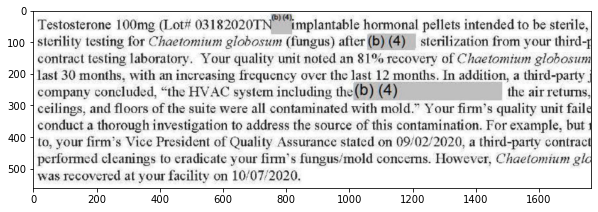

In [65]:
import pytesseract
image = cv2.imread(test_image)
c = line_items_coordinates[13]

img = image[c[0][1]:c[1][1], c[0][0]:c[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(img)

# convert the image to black and white for better OCR
ret,thresh1 = cv2.threshold(img,120,255,cv2.THRESH_BINARY)

# pytesseract image to string to get results
#text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
#print(text)

In [12]:
#from PIL import Image
#
#def convert_pdf_to_image(file_path, output_path):
#    # save temp image files in temp dir, delete them after we are finished
#    with tempfile.TemporaryDirectory() as temp_dir:
#        # convert pdf to multiple image
#        images = convert_from_path(file_path, output_folder=temp_dir)
#        # save images to temporary directory
#        temp_images = []
#        for i in range(len(images)):
#            image_path = f'{temp_dir}/{i}.jpg'
#            images[i].save(image_path, 'JPEG')
#            temp_images.append(image_path)
#        # read images into pillow.Image
#        imgs = list(map(Image.open, temp_images))
#    # find minimum width of images
#    min_img_width = min(i.width for i in imgs)
#    # find total height of all images
#    total_height = 0
#    for i, img in enumerate(imgs):
#        total_height += imgs[i].height
#    # create new image object with width and total height
#    merged_image = Image.new(imgs[0].mode, (min_img_width, total_height))
#    # paste images together one by one
#    y = 0
#    for img in imgs:
#        merged_image.paste(img, (0, y))
#        y += img.height
#    # save merged image
#    merged_image.save(output_path)
#    return output_path
#
#convert_pdf_to_image(pdf, str(temp483images_filepath) + "image.jpeg")

In [13]:
#for pdf in pdfs:
    #download pdf to temp483pdf folder
    #for page in pages:
        #convert page to a png file
        #save that file in temp483images
    #perform OCR on those images
    #save text file as ocr_483_audit (figure the naming convention out)
    #delete images
    #delete pdf

## Step 3: Tidy each document into a corpus

## Step 4: Perform Topic Modeling on Most Recent 1 Year of Drug Observations

## References

__Useful Links__  
https://medium.com/@sarfrazarshad/scraping-dynamically-created-tables-196b7cbe6c84  
https://stackoverflow.com/questions/56757261/extract-href-using-pandas-read-html/56757977  
https://stackoverflow.com/questions/60757571/python-pandas-parse-html-table-to-get-hidden-values-and-links  
https://stackoverflow.com/questions/51092362/selenium-clicking-to-next-page-until-on-last-page